
## Test differences between binned interpolated Eulerian mean field $<\bar u_i>$ and binned "real" Eulerien field, $<\bar u_E>$

Test to run : 

1) Size of bins
2) Number of floats used in bins

In [1]:
import numpy as np

import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram
import dask.dataframe as dd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader

from fsspec.implementations.local import LocalFileSystem

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.5375080.datarmor0/parcels-502090/libparcels_random_fc627a97-8e50-43b3-8b9f-4a6fffd36b5b.so


In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster() #processes=7, cores=7
w = cluster.scale(jobs=3)
#
client = Client(cluster)




In [3]:
client

Client Scheduler: tcp://10.148.1.55:58994 Dashboard: http://10.148.1.55:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [4]:
def read_Ediag(V,diags):
    ds = xr.merge([ut.load_diagnostic(d+"_"+v).rename({v:d+"_"+v}) 
               for v in V for d in diags])

    grid = xr.open_zarr('/home1/datawork/xyu/grid/mit_grid.zarr')
    ds = xr.merge([ds,grid])
    #ds = ds#.isel(i = slice(0,None,4), j = slice(0,None,4), i_g = slice(0,None,4), j_g = slice(0,None,4))
    ds['lon'] = 0*ds.face+ds.XC
    ds['lat'] = 0*ds.face+ds.YC
    ds = ds.compute()
    # Rotation velocity field
    for diag in diags:
        ds['zonal_velocity_'+diag] =  ds[diag+'_SSU'].rename({'i_g': 'i'})*ds.CS - ds[diag+'_SSV'].rename({'j_g': 'j'})*ds.SN
        ds['meridional_velocity_'+diag] =  ds[diag+'_SSU'].rename({'i_g': 'i'})*ds.SN + ds[diag+'_SSV'].rename({'j_g': 'j'})*ds.CS

        ds['lon'] = 0*ds.face+ds.XC
        ds['lat'] = 0*ds.face+ds.YC
 #   ds = llcreader.faces_dataset_to_latlon(ds)
    return ds

In [5]:
# Lagrangian data
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['time_mean'])
df = p.df['time_mean']

df = pa.degs2ms(df) #Convert in m/s 

df = df.persist()

In [6]:
# Eulerian data
V = ["SSU","SSV"]#["SSU", "SSV"]
D = ["mean"]#, "prime_mean","prime_mean_sq"]
ds = read_Ediag(V,D)

In [170]:
def binned_site(bbox,df,dl,V):
    df_sub = df[np.logical_and(df.lat<bbox[3],df.lat>bbox[2]
                                               )].persist()

    df_sub = df[np.logical_and(df.lon<bbox[1],df.lon>bbox[0]
                                          )].persist()
    lon = np.arange(bbox[0],bbox[1], dl)
    lat = np.arange(bbox[-2], bbox[-1], dl)
    df_sub['lon'] = (df_sub['lon']+180)%360 - 180
    df_sub['lon_cut'] = df_sub['lon'].map_partitions(pd.cut, lon)
    df_sub['lat_cut'] = df_sub['lat'].map_partitions(pd.cut, lat)
    df_sub = df_sub.persist()
    uv_sub = df_sub.groupby(['lon_cut','lat_cut']).mean().compute()
    return uv_sub

In [169]:
def localize_Eulerian(bbox,ds):
    ds_sub = ds['zonal_velocity_mean'].where(np.logical_and(ds.lat<=bbox[3],ds.lat>=bbox[2]),drop=True).persist()
    ds_lon = ds['lon'].where(np.logical_and(ds.lat<=bbox[3],ds.lat>=bbox[2]),drop=True).persist()
    ds_lat = ds['lat'].where(np.logical_and(ds.lat<=bbox[3],ds.lat>=bbox[2]),drop=True).persist()
    ds_bis = xr.Dataset({'lon':ds_lon,'zonal_velocity_mean':ds_sub,'lat':ds_lat})
    ds_sub = ds_bis.where(np.logical_and(ds_bis.lon<=bbox[1],ds_bis.lon>=bbox[0]),drop=True).persist()
    lon_E = ds_sub.lon[0,:,0]
    lat_E = ds_sub.lat[0,0,:]
    ds_E = xr.DataArray(ds_sub.isel(face=0)['zonal_velocity_mean'].values,dims=['lon','lat'],coords={'lon':lon_E.values,'lat':lat_E.values})
    return ds_E

In [120]:
len(str(1.))

3

In [138]:
def binned_E_site(bbox,ds_E,dl,V):
 #   ds_E = localize_Eulerian(bbox,ds)
    lon = np.arange(bbox[0],bbox[1], dl)
    lat = np.arange(bbox[-2], bbox[-1], dl)
    df_E = ds_E.to_dataframe(name='mean_SSU').reset_index()

    df_E['lon_cut'] = pd.cut(df_E['lon'],bins=lon)
    df_E['lat_cut'] = pd.cut(df_E['lat'],bins=lat)
    df_Emean = df_E.groupby(['lon_cut','lat_cut']).mean()
    df_Emean['lat'] = np.around(df_Emean.lat.values,decimals=1)

    df_Emean = (df_Emean
     #     .drop(columns=['Coordinates'])
          .set_index(['lon', 'lat'])
         .to_xarray()
        )

#    lat = np.arange(bbox[-2], bbox[-1], dl)
#    lon = np.arange(bbox[0],bbox[1], dl)
#    N = histogram(ds_sub.lat, bins=[lon,lat], 
#              dim=['i', 'j', 'face']
#            ).persist()
#   E = histogram(ds_sub.lat4.rename('lat'), bins=[lat], 
#              weights=ds_sub.SSUV, 
#              dim=['i', 'j', 'face']
#             )

#    E = (E/N).rename('E_SSUV').persist()
#    E = E.rename({'freq_time': 'frequency','lat_bin':'lat_bins'})
    return df_Emean

In [9]:
bbox = [-128, -123, 33, 38] # small bbox

In [10]:
dl = 1.

In [101]:
ds_E = localize_Eulerian(bbox,ds)

In [11]:
df = df.drop(columns=['temperature','salinity','sea_level','Eta_interp','SST_interp','SSS_interp'])

In [12]:
df_L = binned_site(bbox,df,dl,'SSU_interp')

In [13]:
df_L = pa.add_geodata(df_L)

df_L = (df_L
#     .drop(columns=['Coordinates'])
      .set_index(['lon', 'lat'])
     .to_xarray()
    )

df_L

<xarray.Dataset>
Dimensions:              (lat: 4, lon: 4)
Coordinates:
  * lon                  (lon) float64 -127.5 -126.5 -125.5 -124.5
  * lat                  (lat) float64 33.5 34.5 35.5 36.5
Data variables:
    trajectory           (lon, lat) float64 3.73e+07 3.746e+07 ... 3.729e+07
    z                    (lon, lat) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    zonal_velocity       (lon, lat) float64 -0.0353 -0.01968 ... 0.08333
    meridional_velocity  (lon, lat) float64 -0.0866 -0.1057 ... -0.09055 -0.1
    SSU_interp           (lon, lat) float64 -0.0252 -0.02217 ... 0.06306
    SSV_interp           (lon, lat) float64 -0.08629 -0.09746 ... -0.1013

In [92]:
df_Emean = binned_E_site(bbox,ds,dl,V)

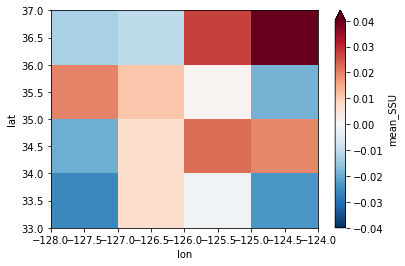

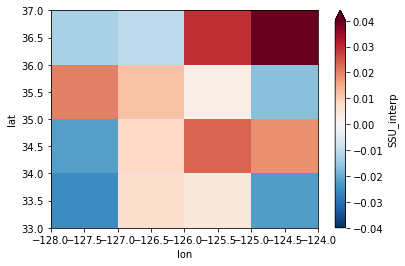

In [93]:
df_Emean.mean_SSU.plot(y='lat',vmax=0.04)
plt.figure()
df_L.SSU_interp.plot(y='lat',vmax=0.04)

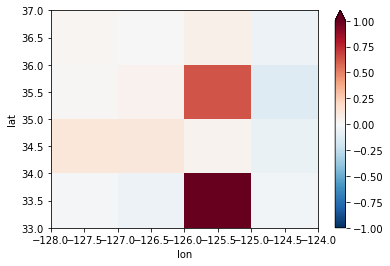

In [94]:
((df_L.SSU_interp-df_Emean.mean_SSU)/df_L.SSU_interp).plot(y='lat',vmax=1,vmin=-1,cmap='RdBu_r')

#### Test bin size:

In [187]:
dl = 2.

In [188]:
df_L = binned_site(bbox,df,dl,'SSU_interp')

In [189]:
df_L = pa.add_geodata(df_L)

df_L = (df_L
#     .drop(columns=['Coordinates'])
      .set_index(['lon', 'lat'])
     .to_xarray()
    )

In [190]:
df_Emean = binned_E_site(bbox,ds_E,dl,V)

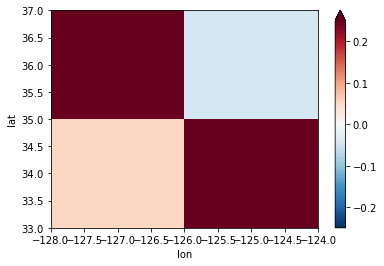

In [191]:
((df_L.SSU_interp-df_Emean.mean_SSU)/df_L.SSU_interp).plot(y='lat',vmax=0.25,cmap='RdBu_r')

In [105]:
dl = 0.5

In [106]:
df_L = binned_site(bbox,df,dl,'SSU_interp')

In [107]:
df_L = pa.add_geodata(df_L)

df_L = (df_L
#     .drop(columns=['Coordinates'])
      .set_index(['lon', 'lat'])
     .to_xarray()
    )

In [122]:
df_Emean = binned_E_site(bbox,ds_E,dl,V)

In [123]:
print(df_L,df_Emean)

<xarray.Dataset>
Dimensions:              (lat: 9, lon: 9)
Coordinates:
  * lon                  (lon) float64 -127.8 -127.2 -126.8 ... -124.2 -123.8
  * lat                  (lat) float64 33.25 33.75 34.25 ... 36.25 36.75 37.25
Data variables:
    trajectory           (lon, lat) float64 3.734e+07 3.729e+07 ... 3.706e+07
    z                    (lon, lat) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    zonal_velocity       (lon, lat) float64 -0.03021 -0.03609 ... -0.0007169
    meridional_velocity  (lon, lat) float64 -0.1136 -0.09103 ... -0.05831
    SSU_interp           (lon, lat) float64 -0.01711 -0.03437 ... -0.01247
    SSV_interp           (lon, lat) float64 -0.1088 -0.09938 ... -0.05464 <xarray.Dataset>
Dimensions:   (lat: 9, lon: 9)
Coordinates:
  * lon       (lon) float64 -127.8 -127.2 -126.8 -126.2 ... -124.8 -124.2 -123.8
  * lat       (lat) float64 33.25 33.75 34.25 34.75 ... 35.75 36.25 36.75 37.25
Data variables:
    mean_SSU  (lon, lat) float32 -0.01737 -0.03475 -0.03527

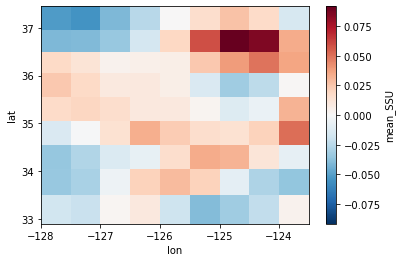

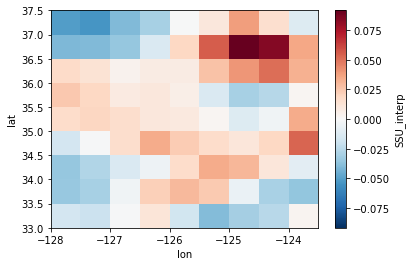

In [113]:
df_Emean.mean_SSU.plot(y='lat')
plt.figure()
df_L.SSU_interp.plot(y='lat')

In [124]:
df_L.SSU_interp-df_Emean.mean_SSU

<xarray.DataArray (lon: 9, lat: 9)>
array([[ 2.62880552e-04,  3.83284444e-04,  3.65218295e-05,
        -2.65763728e-03, -2.04884427e-04,  3.11590696e-04,
        -7.53501562e-04,  2.60872158e-04,  2.04625550e-04],
       [ 3.77019214e-04, -6.96324858e-04,  7.02721666e-06,
         6.84914168e-04, -3.00738152e-06,  9.45755510e-04,
         9.74992490e-04,  3.22387801e-04,  4.92693338e-04],
       [-3.01546799e-03,  5.02683141e-04, -6.15010914e-04,
         1.89016606e-03, -3.92635879e-04, -5.64185220e-04,
        -1.78696488e-04, -3.37250664e-04,  4.75351173e-04],
       [ 2.00567614e-03,  6.65612393e-04,  2.98292498e-03,
         9.81743705e-04,  5.44096713e-04,  9.82940156e-04,
         2.32507265e-03,  2.07392121e-03, -4.68013909e-03],
       [ 1.40871797e-03,  8.01722305e-04,  7.46219858e-04,
         2.87487460e-04, -1.36613324e-04, -2.81554403e-04,
         1.20085252e-03, -1.36765244e-05, -8.96975056e-04],
       [-1.71081981e-04,  2.84532613e-03, -4.19173690e-05,
         9.62489553e-04, -3.83507930e-04,  2.10421255e-04,
         1.94864375e-03, -3.10078312e-03, -6.36188164e-03],
       [ 1.52294173e-03,  2.73833526e-03, -1.70229169e-03,
        -2.46388371e-03,  3.26422325e-04,  2.29570614e-03,
         1.24720089e-03, -1.50948221e-04,  1.14118506e-02],
       [-2.47206586e-03, -1.39104812e-03, -2.13610756e-04,
        -2.14866964e-03,  2.71816543e-03, -1.97832838e-03,
         1.27885539e-03, -1.56487183e-03, -1.79340460e-03],
       [-1.62990499e-03, -3.81629241e-04, -8.93227381e-04,
         1.98047991e-03,  1.92084406e-03,  1.30628622e-03,
        -3.17400167e-03,  1.07344701e-03,  3.00080255e-03]])
Coordinates:
  * lon      (lon) float64 -127.8 -127.2 -126.8 -126.2 ... -124.8 -124.2 -123.8
  * lat      (lat) float64 33.25 33.75 34.25 34.75 35.25 35.75 36.25 36.75 37.25

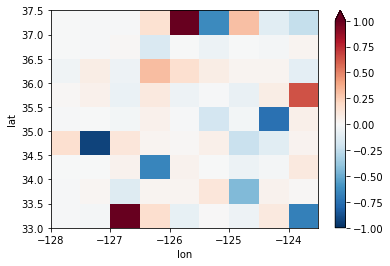

In [125]:
((df_L.SSU_interp-df_Emean.mean_SSU)/df_L.SSU_interp).plot(y='lat',vmax=1,vmin=-1,cmap='RdBu_r')

In [166]:
dl = 4.

In [171]:
df_L = binned_site(bbox,df,dl,'SSU_interp')

In [172]:
df_L = pa.add_geodata(df_L)

df_L = (df_L
#     .drop(columns=['Coordinates'])
      .set_index(['lon', 'lat'])
     .to_xarray()
    )

In [173]:
df_Emean = binned_E_site(bbox,ds_E,dl,V)

In [184]:
print(df_Emean.mean_SSU.values,df_L.SSU_interp.values)

[[0.00440636]] [[0.0040596]]


In [186]:
(df_L.SSU_interp-df_Emean.mean_SSU)/df_L.SSU_interp

<xarray.DataArray (lon: 1, lat: 1)>
array([[-0.0854162]])
Coordinates:
  * lon      (lon) float64 -126.0
  * lat      (lat) float64 35.0

#### Number of drifters

In [130]:
dl = 1.

In [131]:
df_L = binned_site(bbox,df,dl,'SSU_interp')

In [137]:
df_Emean.lat
df_L.lat

<xarray.DataArray 'lat' (lat: 4)>
array([33.5, 34.5, 35.5, 36.5])
Coordinates:
  * lat      (lat) float64 33.5 34.5 35.5 36.5

In [132]:
df_L = pa.add_geodata(df_L)

df_L = (df_L
#     .drop(columns=['Coordinates'])
      .set_index(['lon', 'lat'])
     .to_xarray()
    )

In [139]:
df_Emean = binned_E_site(bbox,ds_E,dl,V)

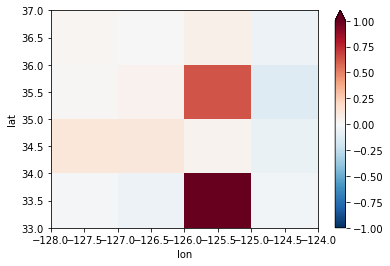

In [140]:
((df_L.SSU_interp-df_Emean.mean_SSU)/df_L.SSU_interp).plot(y='lat',vmax=1,vmin=-1,cmap='RdBu_r')

In [142]:
def binned_site(bbox,df,dl,V):
    df_sub = df[np.logical_and(df.lat<bbox[3],df.lat>bbox[2]
                                               )].persist()

    df_sub = df[np.logical_and(df.lon<bbox[1],df.lon>bbox[0]
                                          )].persist()
    lon = np.arange(bbox[0],bbox[1], dl)
    lat = np.arange(bbox[-2], bbox[-1], dl)
    df_sub['lon'] = (df_sub['lon']+180)%360 - 180
    df_sub['lon_cut'] = df_sub['lon'].map_partitions(pd.cut, lon)
    df_sub['lat_cut'] = df_sub['lat'].map_partitions(pd.cut, lat)
    df_sub = df_sub.persist()
    #uv_sub = df_sub.groupby(['lon_cut','lat_cut']).mean().compute()
    return df_sub#uv_sub

In [143]:
df_sub = binned_site(bbox,df,dl,V)

In [148]:
ids = np.unique(df_sub.trajectory.compute())

In [154]:
df_bis = df_sub.reset_index().set_index('trajectory').compute()#[df_sub.trajectory==ids]

In [157]:
df_10 = df_bis.loc[ids[::10]]

In [158]:
df_10mean = df_10.groupby(['lon_cut','lat_cut']).mean()

In [160]:
df_10mean = pa.add_geodata(df_10mean)

df_10mean= (df_10mean
#     .drop(columns=['Coordinates'])
      .set_index(['lon', 'lat'])
     .to_xarray()
    )

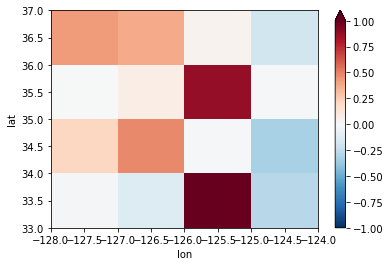

In [165]:
((df_10mean.SSU_interp-df_Emean.mean_SSU)/df_10mean.SSU_interp).plot(y='lat',vmax=1,vmin=-1,cmap='RdBu_r')

In [192]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
